# Project: Vehicle Detection and Tracking

The objective of this project is to build a pipeline to properly identify objects within images (and by extension videos). In this case we are specifically identifying cars and non-cars. I will be using much of the lessons to build this pipeline. The code should be well commented and straight forward so as to explain itself as much as possible. I hope you follow along!

In [1]:
# Import necessary libraries used throughout the notebook
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

%matplotlib inline

### Load training data

In [2]:
cars = []
noncars = []

# populate cars
basedir = "vehicles/"
image_types = os.listdir(basedir)
for imtype in image_types:
    cars.extend(glob.glob(basedir + imtype + '/*'))

# populate non-cars
basedir = "non-vehicles/"
image_types = os.listdir(basedir)
for imtype in image_types:
    noncars.extend(glob.glob(basedir + imtype + '/*'))
    
# write filenames for both into text files
with open('cars.txt', 'w') as f:
    for car in cars:
        f.write(car + '\n')
        
with open('non-cars.txt', 'w') as f:
    for noncar in noncars:
        f.write(noncar + '\n')
        
print('Number of cars:', len(cars))
print('Number of non-cars:', len(noncars))

Number of cars: 8792
Number of non-cars: 8968


## Functions grabbed from the lessons

In [3]:
# Define a function that takes an image and a new image size and returns a feature vector
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins)
    ghist = np.histogram(img[:,:,1], bins=nbins)
    bhist = np.histogram(img[:,:,2], bins=nbins)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, rhist, ghist, bhist, bin_centers

In [39]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [46]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)=
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features, _, _, _, _ = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)=
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)           
        else:
            if vis==True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list=
        img_features.append(hog_features)
    
    #9) Return concatenated array of features
    if vis==True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

In [48]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space, spatial_size, hist_bins, orient, pix_per_cell,
                                           cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
        
        features.append(file_features)
    # Return list of feature vectors
    return features

In [8]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [9]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [12]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

Now let's play around and see what a random car and non-car look like

(768,)
(48,)
(1176,)
(768,)
(48,)
(1176,)


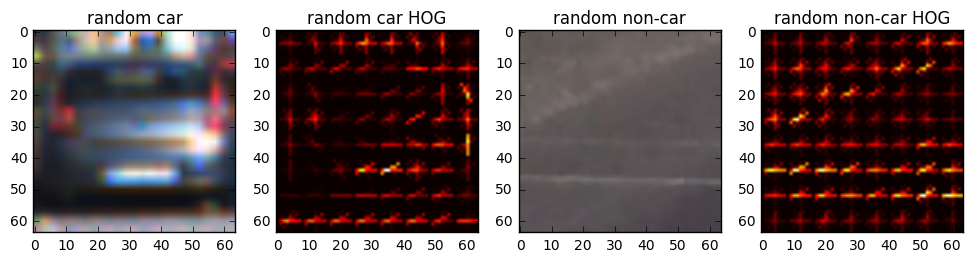

In [29]:
car_idx = np.random.randint(0, len(cars))
non_car_idx = np.random.randint(0, len(noncars))

random_car = mpimg.imread(cars[car_idx])
random_non_car = mpimg.imread(noncars[non_car_idx])

# params
color_space = 'RGB'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16, 16) # down sample size
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

random_car_features, random_car_hog_image = single_img_features(random_car, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

random_non_car_features, random_non_car_hog_image = single_img_features(random_non_car, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [random_car, random_car_hog_image, random_non_car, random_non_car_hog_image]
titles = ['random car', 'random car HOG', 'random non-car', 'random non-car HOG']
fig = plt.figure(figsize=(12,3))

visualize(fig, 1, 4, images, titles)

Great. Now let's extend...

In [49]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, 'ALL'
spatial_size = (16, 16) # down sample size
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

n_samples = 1000
rand_idxs = np.random.randint(0, len(cars), n_samples)

test_cars = np.array(cars)[rand_idxs]
test_notcars = np.array(noncars)[rand_idxs]

t = time.time()

car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)


non_car_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# how long did it take?
print(time.time()-t, "seconds to compute features")

# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)
# per-column scaler
X_scaler = StandardScaler().fit(X)
# apply scaler to X
scaled_X = X_scaler.transform(X)

# labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

# display useful information
print('Using:', orient, 'orientation,', pix_per_cell, 'pixels per cell,', cell_per_block, 'cells per block,',
     hist_bins, 'histogram bins,', spatial_size, 'spatial sampling')
print('Feature vector length', len(X_train[0]))

# using SVC
svc = LinearSVC()

# fit to SVC and track time
t = time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC')

# display accuracy
print('Test accuracy of SVC =', round(svc.score(X_test, y_test), 4))


(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)
(5292,)
(768,)
(96,)


In [ ]:
# attempt to draw windows on 6 test_images
searchpath = 'test_images/*'
test_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [None, None]
overlap = 0.5

for filename in test_images:
    t1 = time.time()
    img = mpimg.imread(filename)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=(128, 128), xy_overlap=(overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    
    print(time.time()-t1, 'seconds to process a large image', len(windows), 'windows')
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
    
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)